In [1]:
import pandas as pd
from formulae import design_matrices
import pymc as pm
import pymc.sampling_jax
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

In [2]:
#%conda install -c conda-forge formulae
import lux
import luxwidget

# Cherry blossom data set

You may recognize this data set from the cover of McElreath's Statistical Rethinking book.  In Chapter 4 the book goes over fitting a spline model to the temperature as a function of time.  We'll use three columns of the data set, 
- `doy` the day of year of the first bloom
- `temp` the temperature (since it goes so far back in time, I'm not sure how it's reconstructed)
- `year` is of course the year

In [3]:
df = pd.read_csv(pm.get_data("cherry_blossoms.csv"), sep=";")
df.temp_upper.dropna()


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [4]:

df = df[["year", "doy", "temp", 'temp_upper']].dropna()

In [5]:
df

/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/IPython/core/formatters.py:922: UserWarning:
Unexpected error in rendering Lux widget and recommendations. Falling back to Pandas display.
Please report the following issue on Github: https://github.com/lux-org/lux/issues 

/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/lux/core/frame.py:628: UserWarning:Traceback (most recent call last):
  File "/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/lux/core/frame.py", line 577, in _ipython_display_
    self.maintain_metadata()
  File "/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/lux/core/frame.py", line 143, in maintain_metadata
    self.compute_metadata()
  File "/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/lux/core/frame.py", line 126, in compute_metadata
    lux.config.executor.compute_dataset_metadata(self)
  File "/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site

year    doy  temp  temp_upper
50     851  108.0  7.38       12.10
63     864  100.0  6.42        8.69
65     866  106.0  6.44        8.11
88     889  104.0  6.83        8.48
90     891  109.0  6.98        8.96
...    ...    ...   ...         ...
1175  1976   99.0  8.20        8.77
1176  1977   93.0  8.22        8.78
1177  1978  104.0  8.20        8.78
1178  1979   97.0  8.28        8.83
1179  1980  102.0  8.30        8.86

[787 rows x 4 columns]

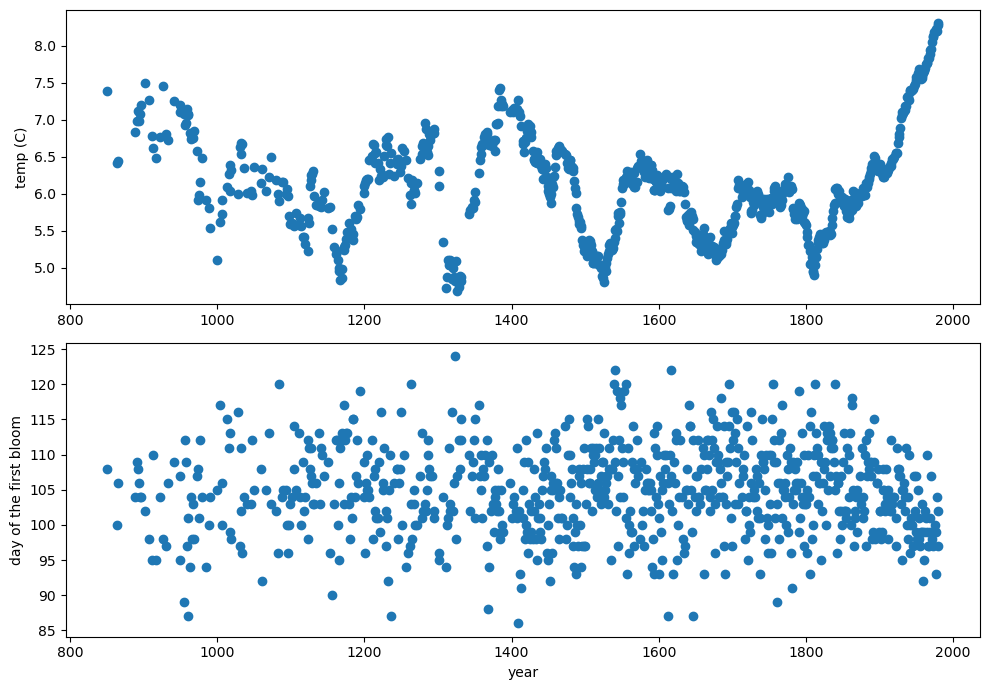

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7)); axs = axs.flatten()

axs[0].scatter(df["year"], df["temp"])
axs[1].scatter(df["year"], df["doy"])

axs[1].set_xlabel("year")
axs[0].set_ylabel("temp (C)")
axs[1].set_ylabel("day of the first bloom")
fig.tight_layout()

We'll start by fitting the temperature as a function of `year` using first polynomials, then splines, then GPs.  

# Polynomial features

We'll use orthogonalized polynomials (as per http://davmre.github.io/blog/python/2013/12/15/orthogonal_poly) to generate our basis.  This keeps our features from being correlated with each other, and makes it much easier to set priors on the coefficients since they're on the same scale.  We'll plot the basis below.  You can see that each feature is non-zero across the whole range of the data.

In [7]:
def ortho_poly_fit(x, degree = 1):
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
            stop("'degree' must be less than number of unique points")
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q,r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)

    norm2 = np.sum(raw**2, axis=0)
    alpha = (np.sum((raw**2)*np.reshape(x,(-1,1)), axis=0)/norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z, norm2, alpha

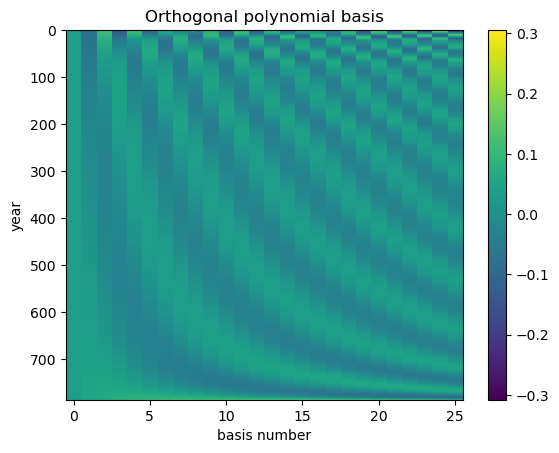

In [8]:
Z, _, _ = ortho_poly_fit(df["year"].values, degree=25)
m = plt.imshow(Z, aspect='auto', interpolation='none');
plt.colorbar(m)
plt.title("Orthogonal polynomial basis");
plt.ylabel("year");
plt.xlabel("basis number");

In [9]:
coords = {
    "year": df.year.tolist()
}
with pm.Model(coords=coords) as model:
    beta = pm.Normal("beta", mu=0.0, sigma=5, size=Z.shape[1])
    f = pm.Deterministic("f", Z @ beta, dims="year")
    
    sigma = pm.HalfNormal("sigma", sigma=2*np.std(df["temp"].values))
    pm.Normal("y", mu=f, sigma=sigma, observed=df["temp"].values)

In [10]:
def sample(model, target_accept=0.8):
    """ Simple sampling function so we can keep the same settings
    """
    with model:
        idata = pm.sampling_jax.sample_numpyro_nuts(tune=1000, draws=1000, target_accept=target_accept)
    print("Divergences:", int(idata.sample_stats.diverging.sum().values))
    return idata

idata_poly = sample(model)

Compiling...
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Compilation time = 0:00:01.530000
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:03.605477
Transforming variables...
Transformation time = 0:00:00.241101


Divergences: 0


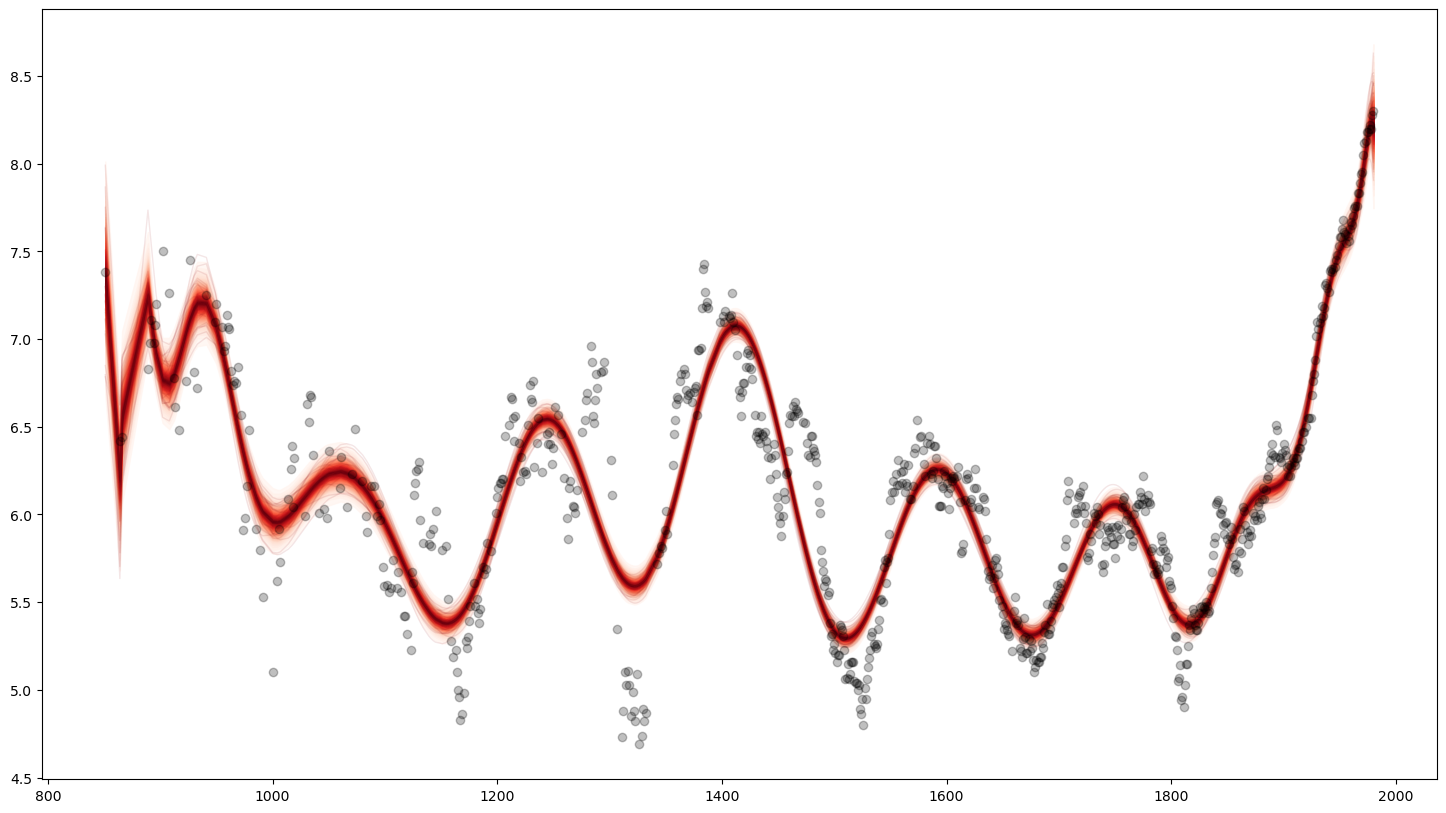

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));

f = az.extract(idata_poly, group="posterior", var_names="f")
pm.gp.util.plot_gp_dist(ax=ax, samples=f.values.T, x=df["year"].values)
ax.plot(df["year"].values, df["temp"].values, "ok", alpha=0.25);

We can see visually that the fit isn't amazing.  It looks like the polynomial isn't flexible enough to fit the data as well as at could, so we see underfitting.  You can try increasing the number of polynomials, but you may find other issues.  Of course, we can't use this method to forecast future temperatures since polynomials will go off into arbitrary directions outside the range of the data.

Further reading: 
- http://alumni.media.mit.edu/~tpminka/statlearn/demo/
- https://www.cs.cmu.edu/~andrewgw/andrewgwthesis.pdf (Section 1.2)
- https://stats.stackexchange.com/questions/560383/how-can-we-explain-the-bad-reputation-of-higher-order-polynomials

# Splines

We can generate our B-spline basis using the [formulae package](https://github.com/bambinos/formulae) for mixed effects models that's used by [Bambi](https://github.com/bambinos/bambi). (which also now implements HSGPs!).  We'll use the same order as the polynomial model for comparison.

In [24]:
num_knots = 25
knots = np.quantile(df["year"].values, np.linspace(0, 1, num_knots))
iknots = knots[1:-1]

dm = design_matrices("bs(year, knots=iknots, intercept=True)", data=df)
X = dm.common.design_matrix

with pm.Model(coords=coords) as model:
    beta = pm.Normal("beta", mu=0.0, sigma=10, size=X.shape[1])
    f = pm.Deterministic("f", X @ beta, dims="year")
    
    sigma = pm.HalfNormal("sigma", sigma=2*np.std(df["temp"].values))
    pm.Normal("y", mu=f, sigma=sigma, observed=df["temp"].values)

In [25]:
idata_bs = sample(model)

Compiling...
Compilation time = 0:00:01.053344
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:05.025112
Transforming variables...
Transformation time = 0:00:00.126634


Divergences: 0


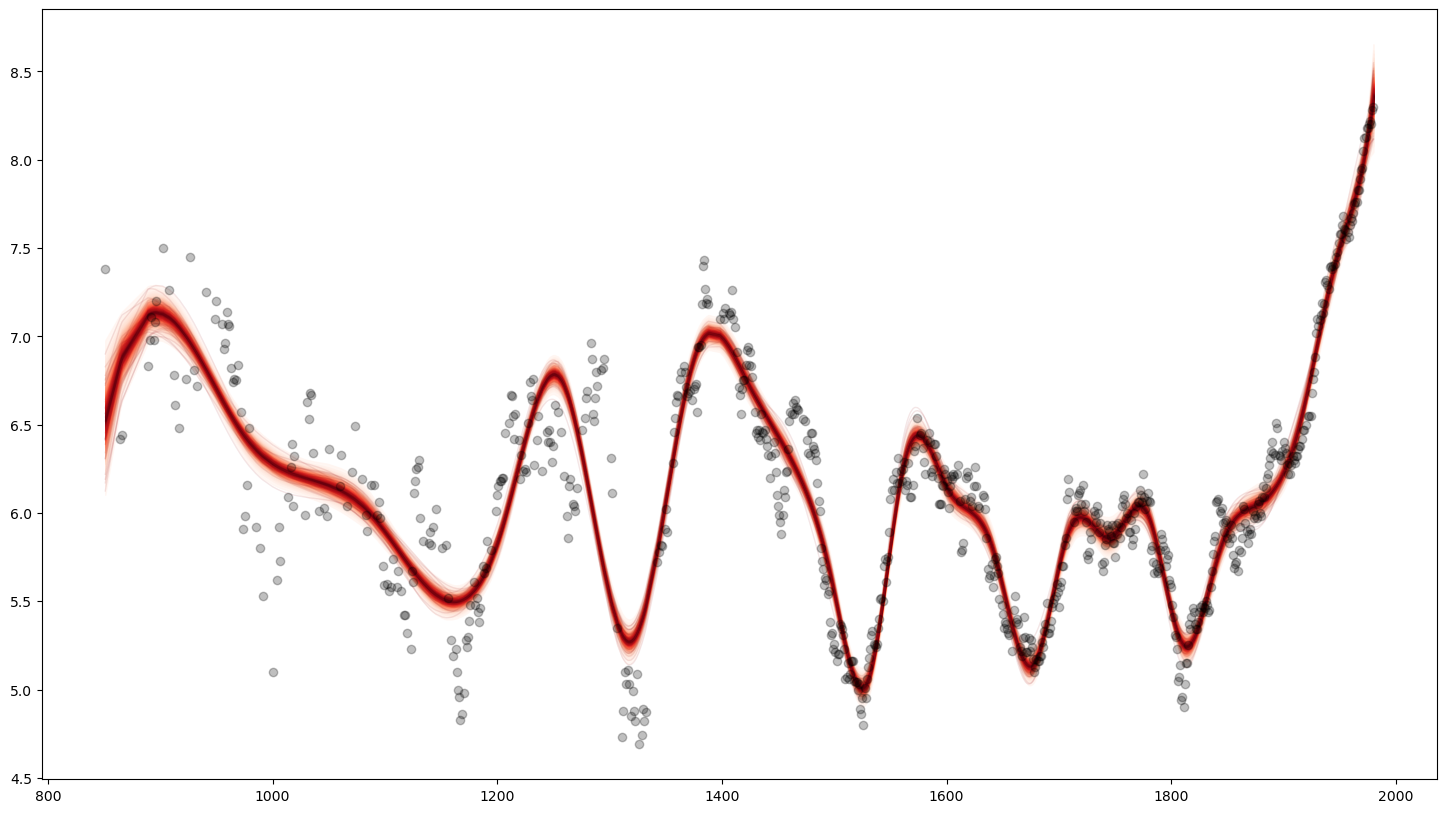

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));

f = az.extract(idata_bs, group="posterior", var_names="f")
pm.gp.util.plot_gp_dist(ax=ax, samples=f.values.T, x=df["year"].values)
ax.plot(df["year"].values, df["temp"].values, "ok", alpha=0.25);

You'll see that it's very similar to the polynomial fit.  Let's increase the order way up to 400 and refit.  It looks like it pretty dramatically overfits.  If you try increasing the polynomial up to degree 400, you may notice some problems that splines don't have here.  We still don't know what the "best" number of knots is.  

In [27]:
num_knots = 400
knots = np.quantile(df["year"].values, np.linspace(0, 1, num_knots))
iknots = knots[1:-1]

dm = design_matrices("bs(year, knots=iknots, intercept=True)", data=df)
X = dm.common.design_matrix

with pm.Model(coords=coords) as model:
    beta = pm.Normal("beta", mu=0.0, sigma=10, size=X.shape[1])
    f = pm.Deterministic("f", X @ beta, dims="year")
    
    sigma = pm.HalfNormal("sigma", sigma=2*np.std(df["temp"].values))
    pm.Normal("y", mu=f, sigma=sigma, observed=df["temp"].values)

In [28]:
idata_bs2 = sample(model)

Compiling...


Compilation time = 0:00:00.653278
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:02.312757
Transforming variables...
Transformation time = 0:00:00.391635


Divergences: 0


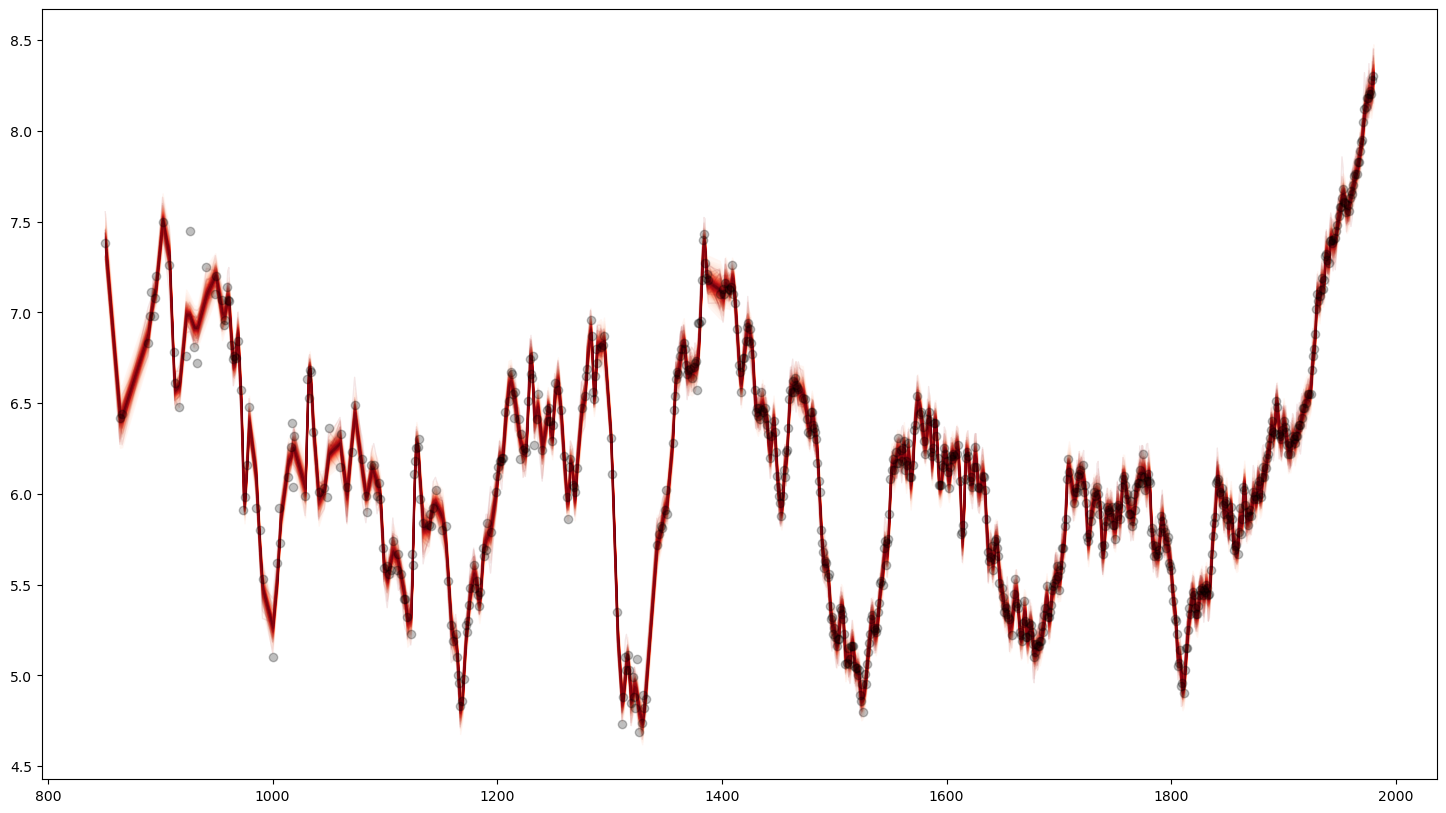

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));

f = az.extract(idata_bs2, group="posterior", var_names="f")
pm.gp.util.plot_gp_dist(ax=ax, samples=f.values.T, x=df["year"].values)
ax.plot(df["year"].values, df["temp"].values, "ok", alpha=0.25);

# GP on Cherry Blossom data

We'll start by using a GP with a Matern$^{\frac{5}{2}}$ kernel.  Before using the HSGP approximation, we'll start with a vanilla GP first.  I encourage you to check the source code for `pm.gp.Latent` to see how vanilla the implementation is for yourself.  

What's nice about GPs vs splines is that you make a different set of modeling decisions.  The world of kernels is huge, but as a starting point let's stay in the Matern family of kernels and let's try to answer the questions:
1. How "choppy" or smooth is the function?
2. Over what time scale does the function change a lot?

To me, these questions are easier to reason about than choosing splines, locating knots, polynomial degrees, etc.  Also, we are free to extrapolate as far as we want to!  How good those predictions are is another question, but there aren't any rakes to step on here.  For question 1, on the spectrum between random walk and super smooth (aka, infinitely differentiable) let's answer, "medium-ish?", so, the Matern$^{\frac{5}{2}}$ kernel it is.  For the second question, let's put a prior that constrains the lengthscale to roughly be between 10 and 200 years.

## These two examples are SLOW.  Skip unless you're on a big computer.

In [91]:
with pm.Model(coords=coords) as model:
    # Set prior on GP hyperparameters
    eta = pm.Exponential("eta", lam=0.25)
    
    ell_params = pm.find_constrained_prior(
        pm.InverseGamma, 
        lower=10, upper=200, 
        init_guess={"alpha": 2, "beta": 20}, 
    )
    ell = pm.InverseGamma("ell", **ell_params)
    
    # Specify covariance function and GP
    cov = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=df["year"].values[:, None], dims="year")
    
    intercept = pm.Normal("intercept", mu=df["temp"].mean(), sigma=2 * df["temp"].std())
    mu = pm.Deterministic("mu", intercept + f, dims="year")
    
    sigma = pm.HalfNormal("sigma", sigma=2 * df["temp"].std())
    pm.Normal("y", mu=f, sigma=sigma, observed=df["temp"].values)

/Users/andre/miniconda3/envs/hsgp-env/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op gammaincc_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/andre/miniconda3/envs/hsgp-env/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op gammaincc_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(


In [10]:
# dont even bother
# idata_gp = sample(model)

Well, never mind.  I canceled it because it was taking too long.  Since we have a normal likelihood, we can marginalize out the actual GP `f`.  For more information see: https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/gaussian_processes/GP-Marginal.html.  We can get the GP `f` after sampling using the `.conditional`, but it's an extra step.  The code below is the exact same model as above, but it uses some 

In [12]:
with pm.Model(coords=coords) as model:
    # Set prior on GP hyperparameters
    eta = pm.Exponential("eta", lam=0.25)
    ell_params = pm.find_constrained_prior(
        pm.InverseGamma, 
        lower=20, upper=200, 
        init_guess={"alpha": 2, "beta": 20}, 
        mass=0.95,
    )
    ell = pm.InverseGamma("ell", **ell_params)
    
    # Specify covariance function and GP
    cov = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    
    intercept = pm.Normal("intercept", mu=df["temp"].mean(), sigma=2 * df["temp"].std())
    mu = pm.gp.mean.Constant(intercept)
    
    gp = pm.gp.Marginal(mean_func=mu, cov_func=cov)
    
    sigma = pm.HalfNormal("sigma", sigma=2 * df["temp"].std())
    gp.marginal_likelihood("y", X=df["year"].values[:, None], y=df["temp"].values, sigma=sigma)

/Users/andre/miniconda3/envs/hsgp-env/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op gammaincc_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/andre/miniconda3/envs/hsgp-env/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:694: UserWarning: Rewrite warning: The Op gammaincc_der does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(


In [ ]:
with model:
    idata_gp = pm.sampling_jax.sample_numpyro_nuts(tune=1000, draws=1000, target_accept=0.8, idata_kwargs={"log_likelihood": False})
print("Divergences:", int(idata.sample_stats.diverging.sum().values))

Compiling...
Compilation time =  0:00:07.442041
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2023-03-20 22:59:54.318455: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  reduce.95 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-03-20 22:59:54.861444: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 1.547921s
Constant folding an instruction is taking > 1s:

  reduce.95 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't nece

Sampling time =  0:33:07.464206
Transforming variables...
Transformation time =  0:00:00.012119
Computing Log Likelihood...


# HSGP

Since the likelihood is normal, we could use resort to using `pm.gp.MarginalApprox`, but that is likely slower than HSGPs!  We'd also have to make additional decisions about where to locate the inducing points (which are somewhat analogous to spline knots).

HSGP is a drop in replacement for `pm.gp.Latent`, or the vanilla GP.  There isn't a need to fuss with marginalizing it out, not sampling the GP directly and trying to get it back later.  The only thing we need to choose are `m` and `c` (or `L`).  `m` controls the number of basis vectors to use, and `c` or `L` control the boundary where the approximation is accurate.  You can read `c` as the multiple on the half range of the data over which the approximation is accurate.  For instance, if your `x` data goes between -5 and 5, and you want the GP approximation to be accurate from -10 to 10, you'll need to choose `c` to be *at least* 2.

Some rules of thumb are:

- Larger `m` means we can use smaller lengthscales (more wiggly)
- Larger `c` means we can use larger lengthscales

In [Ruitort-Mayol et. al.'s paper](https://arxiv.org/pdf/2004.11408.pdf), they give some recommendations for choosing `m` and `c` that we can plot below.  

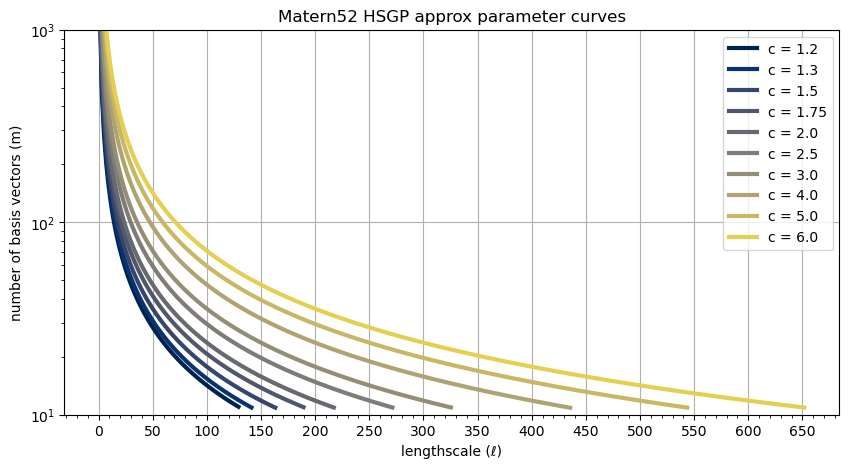

In [11]:
from matplotlib.ticker import MultipleLocator

c_list = np.array([1.2, 1.3, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0])
ell = np.linspace(1, 1000, 500)
S = (df["year"] - df["year"].mean()).max() # half-range of the input data

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

cmap = plt.cm.cividis
colors = np.arange(len(c_list)) / len(c_list)

for i, c in enumerate(c_list):
    m = 2.65 * (c / ell) * S
   
    ix = c >= (4.1 * (ell / S))
    m[~ix] = np.nan
    ax.semilogy(ell, m, color=cmap(colors[i]), label="c = %s" % str(c), lw=3);

ax.grid(True);

ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(10))

ax.set_title("Matern52 HSGP approx parameter curves");
ax.set_ylim([10, 1000]);
ax.set_xlabel("lengthscale (ℓ)");
ax.set_ylabel("number of basis vectors (m)");
ax.legend();

The curves show the regions where the HSGP approximation is accurate.  For instance, the darkest blue line at $c=1.2$ means that if we choose $c=1.2$, our approximation will be valid for the smallest lengthscales up until about $\ell = 130$.  The yellow curve at $c=6.0$ means shows that the approximation is accurate up until about $\ell = 650$.  **How we choose these values depends on our prior for the lengthscale**.  In our case we are setting 95% of the prior mass between 20 and 200.  We'll be safe and choose $c=2$ and $m=400$ so our prior range is well covered pretty well.  

Also, keep in mind that HSGP scales as $\mathcal{O}(nm + m)$, so the smaller we can choose $m$, the better, speed-wise.  $c$ plays no role in computation speed.

In [12]:
def belk_find_constrained_prior(dist, lower, upper, init_guess, mass=0.95, plot_out=True):
    """ Find a constrained prior for a distribution
    """
    con_pri = pm.find_constrained_prior(dist, lower=lower, upper=upper, init_guess=init_guess, mass=mass)
    con_pri_rounded = {k: round(v, 2) for k, v in con_pri.items()}
    
    y = dist.dist(**con_pri, size=1000).eval()
    
    if plot_out:
        az.plot_dist(y, quantiles=[0.25, 0.5, 0.75])
        plt.title(f"Prior for {dist.__name__}{con_pri_rounded}")
        plt.gca().axes.get_yaxis().set_visible(False)
        
    return con_pri_rounded


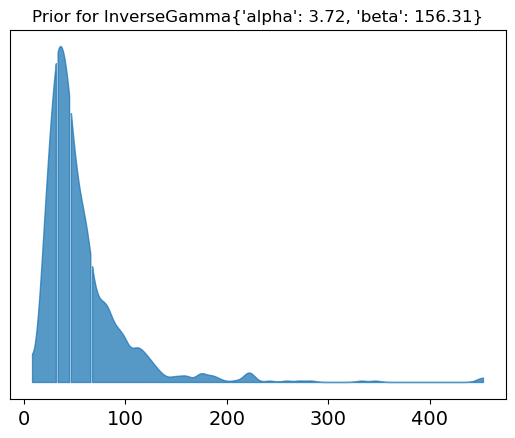

In [80]:
with pm.Model(coords=coords) as model:
    # Set prior on GP hyperparameters
    eta = pm.Exponential("eta", lam=0.25)
    
    ell_params = belk_find_constrained_prior(
        pm.InverseGamma, 
        lower=20, upper=200, 
        init_guess={"alpha": 2, "beta": 20},
        mass=0.95,
    )
    ell = pm.InverseGamma("ell", **ell_params)
    
    # Specify covariance function and GP
    cov = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    gp = pm.gp.HSGP(m=[400], c=2.0, cov_func=cov)
    f = gp.prior("f", X=df["year"].values[:, None], dims="year")
    
    intercept = pm.Normal("intercept", mu=df["temp"].mean(), sigma=2 * df["temp"].std())
    mu = pm.Deterministic("mu", intercept + f, dims="year")
    
    sigma = pm.HalfNormal("sigma", sigma=2 * df["temp"].std())
    pm.Normal("y", mu=mu, sigma=sigma, observed=df["temp"].values)

In [54]:
idata_gp = sample(model)

Compiling...


Compilation time = 0:00:38.347516
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:44.147923
Transforming variables...
Transformation time = 0:00:00.840899


Divergences: 0


<Figure size 640x480 with 0 Axes>

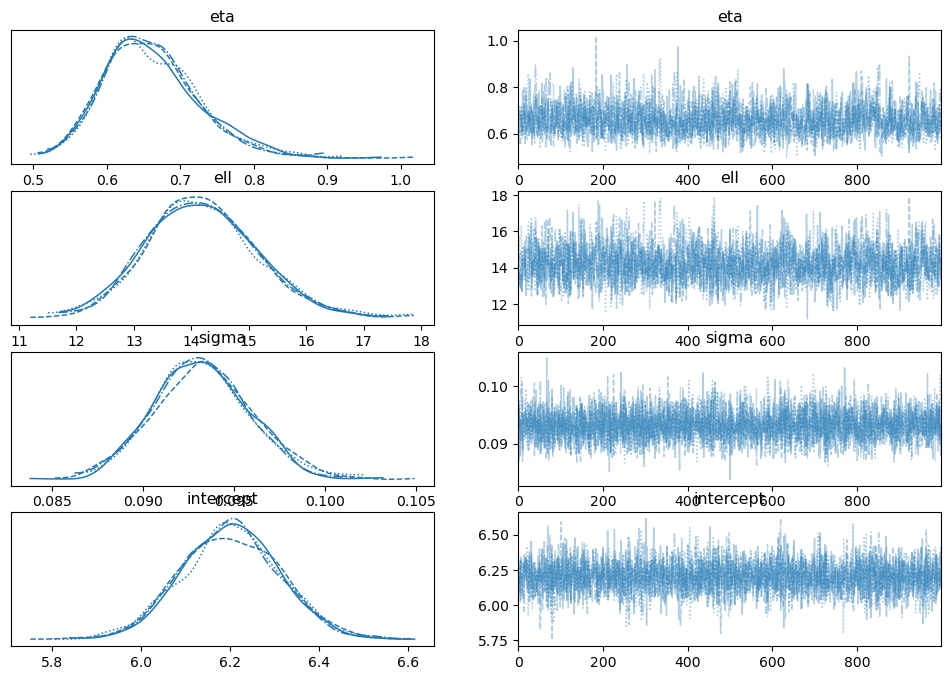

In [67]:

az.plot_trace(idata_gp, var_names=["eta", "ell", "sigma", "intercept"])


This took a few minutes on my machine.  It's definitely slower than the spline models, but we obtained results that look much better.  Compare to when we used a spline with 400 knots.  NUTs depends a ton on the posterior geometry, and sampling the GP hyperparameters has a huge influence, but the speeds are still comparable.  We also see a lengthscale of about 40, which we can interpret as meaning that it takes about 40 years for significant changes in temperature to occur.  We can also interpret this to roughly mean that the GP is comfortable predicting out about 40 years.  

In [81]:
idata_gp

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

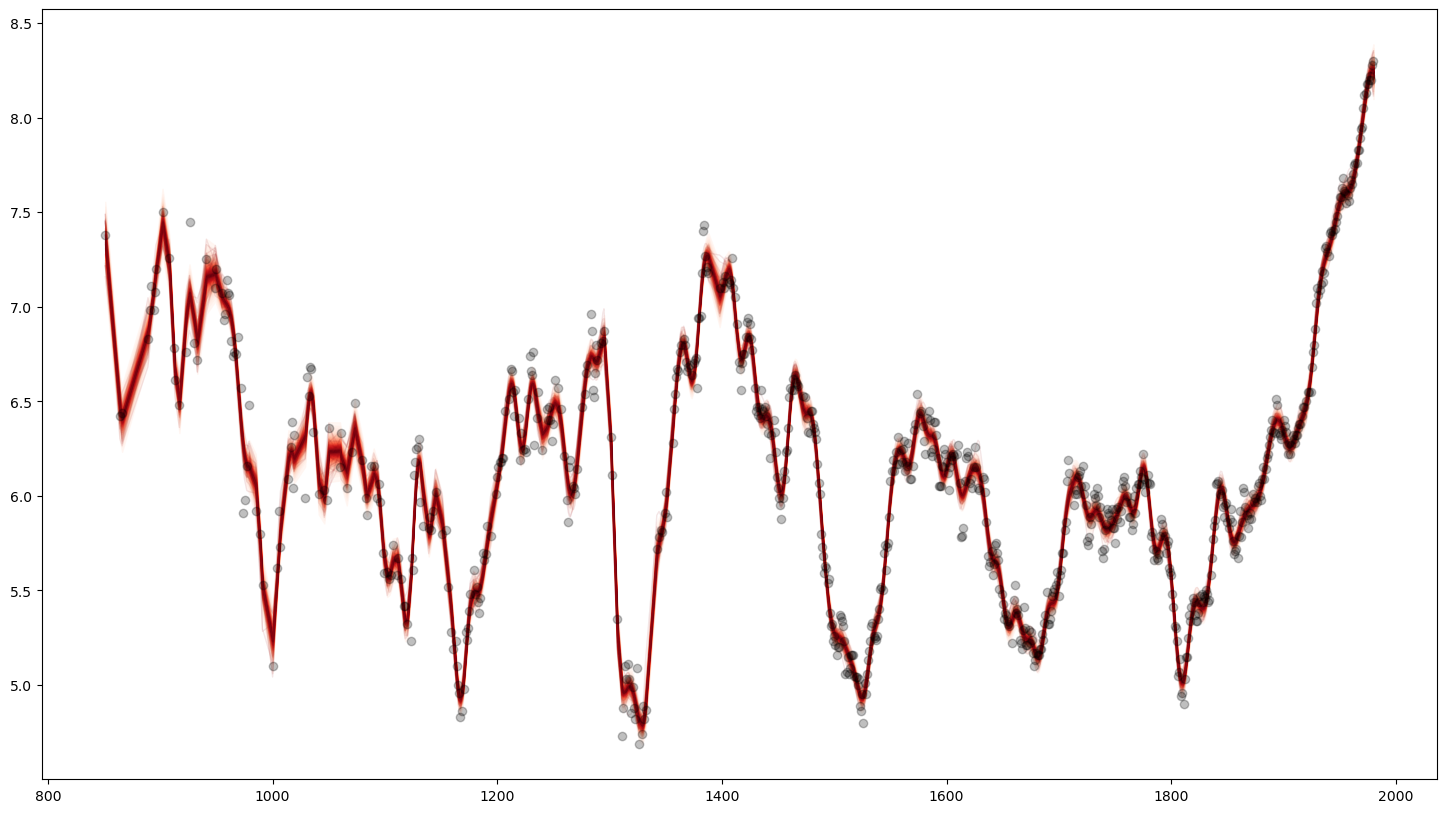

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));

mu = az.extract(idata_gp, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=mu.values.T, x=df["year"].values)
ax.plot(df["year"].values, df["temp"].values, "ok", alpha=0.25);

## Temperature forecast

We can use `gp.conditional` to make predictions at new points, just like the rest of the GP module.  But let's demonstrate the use of the `gp.prior_linearized` function so we can use `pm.set_data`, just as we would with a regular linear model.  It may not make physical sense to try to forecast temperature (or really, be much much more complicated than this), but we'll give it a try anyway.

To predict this way we need to use `L` instead of `c`.  We can see the `L` that the previous model calculated from `c` and `X`.

In [44]:
gp.L.eval()

array([1365.])

In [45]:
x = df["year"].values

with pm.Model(coords=coords) as model-original:
    # Set prior on GP hyperparameters
    eta = pm.Exponential("eta", lam=0.25)
    ell_params = pm.find_constrained_prior(
        pm.InverseGamma, 
        lower=20, upper=200, 
        init_guess={"alpha": 2, "beta": 20},
        mass=0.95,
    )
    ell = pm.InverseGamma("ell", **ell_params)
    
    # Specify covariance function and GP
    cov = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    gp = pm.gp.HSGP(m=[400], L=[1365.0], cov_func=cov)
    
    x_mu = np.mean(x)
    X = pm.MutableData("X", x[:, None])
    X = X - x_mu
    
    phi, sqrt_psd = gp.prior_linearized(X)
    
    ## Centered parameterization
    # When the GP is much stronger than the noise, this parameterization can work better
    beta = pm.Normal("beta", mu=0.0, sigma=sqrt_psd)
    f = pm.Deterministic("f", phi @ beta) 
    
    ## Non-centered parameterization
    #beta = pm.Normal("beta", size=400)
    #f = pm.Deterministic("f", phi @ (beta * sqrt_psd)) 
    
    intercept = pm.Normal("intercept", mu=df["temp"].mean(), sigma=2 * df["temp"].std())
    mu = pm.Deterministic("mu", intercept + f)
    
    sigma = pm.HalfNormal("sigma", sigma=2 * df["temp"].std())
    pm.Normal("y", mu=mu, sigma=sigma, observed=df["temp"].values)

SyntaxError: cannot assign to expression (1179557652.py, line 3)

In [244]:
import pytensor as pt

In [202]:
x = df["year"].values

with pm.Model() as model:
    model.add_coord('year', df.year.tolist(),mutable=True)
    # Set prior on GP hyperparameters
    eta = pm.Exponential("eta", lam=0.25, shape=1)
    ell_params = pm.find_constrained_prior(
        pm.InverseGamma, 
        lower=20, upper=200, 
        init_guess={"alpha": 2, "beta": 20},
        mass=0.95,
    )
    ell = pm.InverseGamma("ell", **ell_params)
    
    # Specify covariance function and GP
    cov = eta[0]**2 * pm.gp.cov.Matern52(1, ls=ell)
    
    intercept = pm.Normal("intercept", mu=df["temp"].mean(), sigma=2 * df["temp"].std())
    
    gp = pm.gp.HSGP(m=[400], L=[1565.0], cov_func=cov, mean_func=pm.gp.mean.Constant(intercept))
    
    x_mu = pm.ConstantData('x_mu',np.mean(x))
    X = pm.MutableData(f"X_mu_{x_mu}", x[:, None])
    X = X 
    

    f = gp.prior("f", X=X, dims="year")
    
    mu = pm.Deterministic("mu",  f, dims="year")
    
    sigma = pm.HalfNormal("sigma", sigma=2 * df["temp"].std())
    pm.Normal("y", mu= f, sigma=sigma, observed=df["temp"].values, shape=X.shape[0 ])


/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/cov.py:190: UserWarning:Only 1 column(s) out of Shape_i{1}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.


In [203]:
idata_gp = sample(model)

Compiling...
Compilation time = 0:00:03.050781
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:54.230097
Transforming variables...
Transformation time = 0:00:00.810560


Divergences: 0


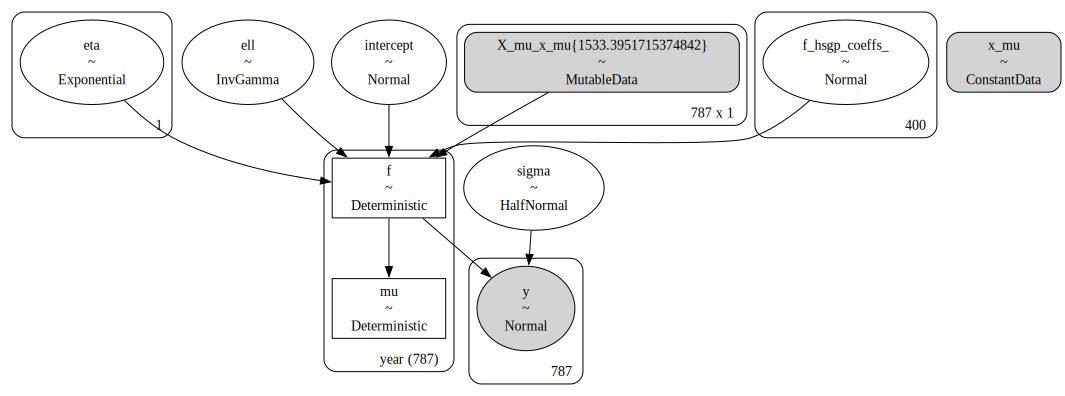

In [204]:
# Assuming your model is named 'model'
pm.model_to_graphviz(model)

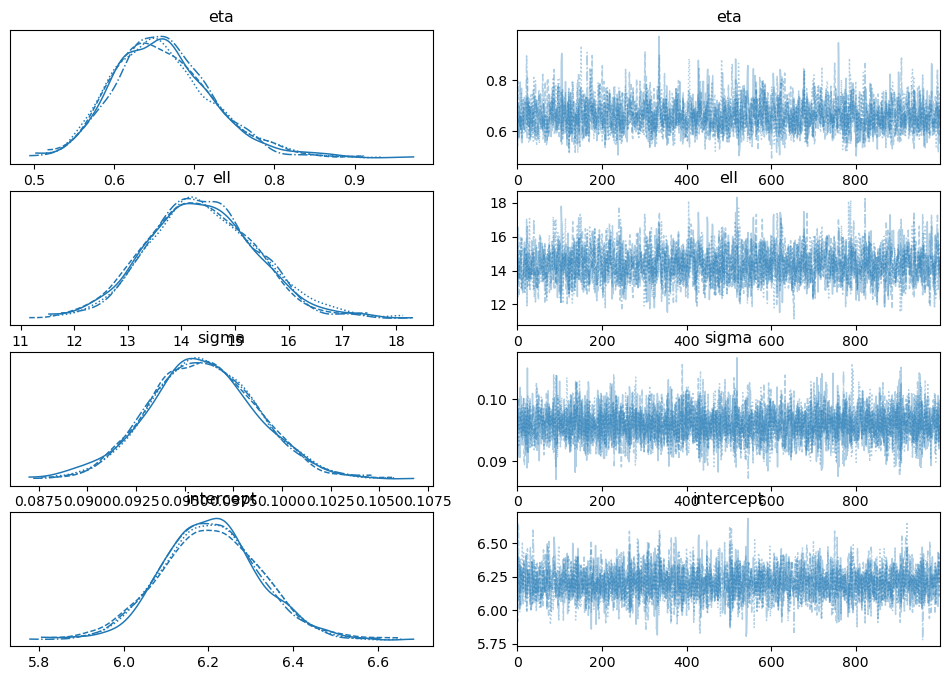

In [205]:
az.plot_trace(idata_gp, var_names=["eta", "ell", "sigma", "intercept"]);

In [137]:
from scipy.stats import norm
mu_int_fit,std_int_fit=norm.fit(idata_gp.posterior.intercept.values)

#idata_gp.posterior.intercept
mu_int_fit,std_int_fit


(6.203999023526871, 0.11651785206775231)

In [295]:

def extend_x_keep_mean(x_extension=50, target_mean=np.mean(x), x=x, make_int=True):
    maintain_mean_of_x_halfwidth = x_extension + np.max(x) - target_mean
    x_new = np.arange((target_mean - maintain_mean_of_x_halfwidth), 
                      (target_mean + maintain_mean_of_x_halfwidth))
    if make_int:
        x_new = x_new.astype(int)
    print(f'{x_new.mean()-target_mean=}')
    return x_new

x_new = extend_x_keep_mean()

    



x_new.mean()-target_mean=-0.6527367338294905


In [ ]:

with model:
    model.set_dim("year", new_length=len(x_new),coord_values=x_new.tolist())
    model.set_data(name=f"X_mu_{x_mu}",values=x_new[:, None], coords={"year": x_new.tolist()})
    ppc = pm.sample_posterior_predictive(idata_gp, var_names=[ 'f','y'])
    
pm.model_to_graphviz(model)

In [207]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [167]:
 (year_gp.mean()- year_ppc.mean())

0.8951715374842024

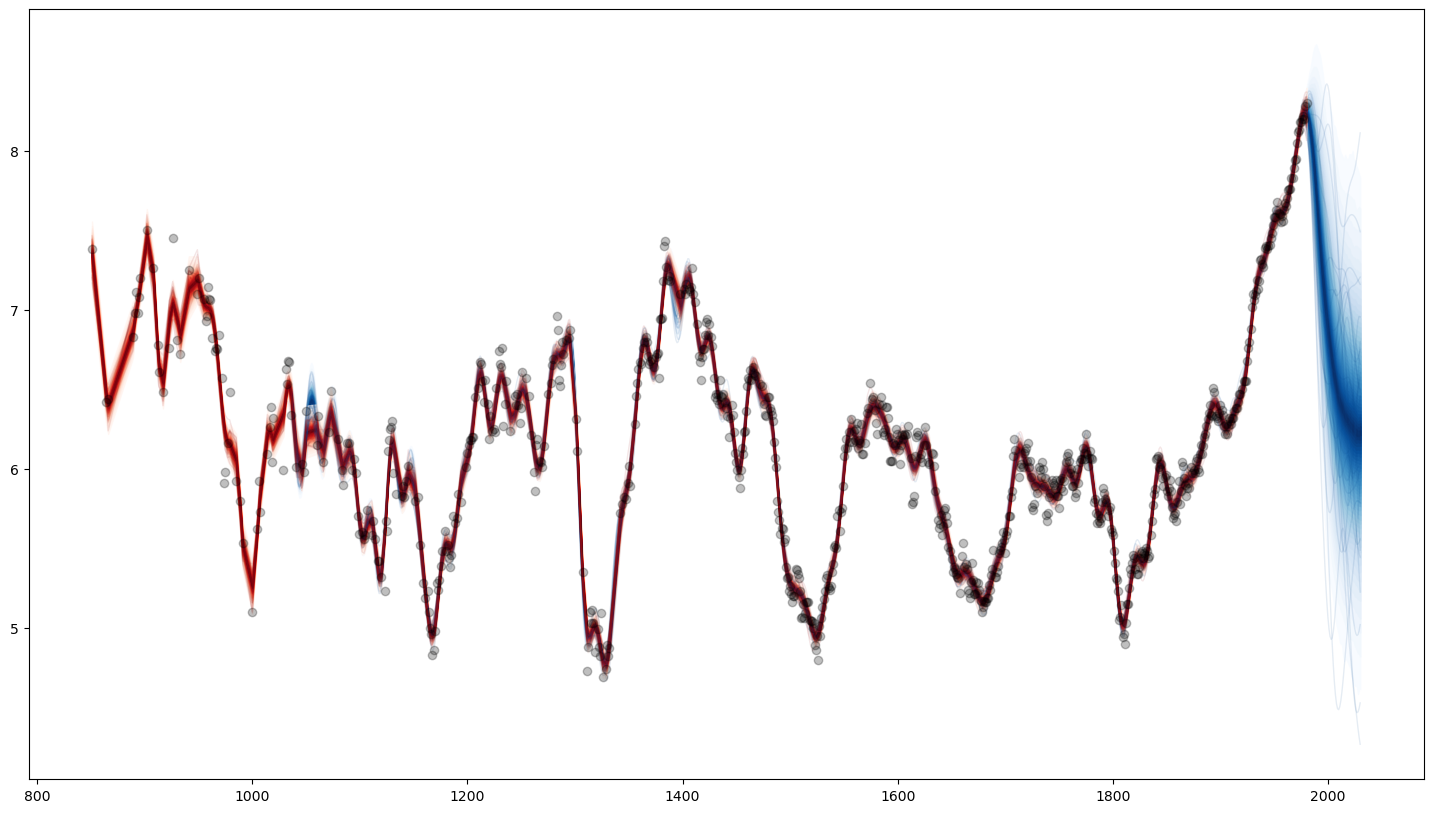

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));
year_gp = idata_gp.posterior.year.values
year_ppc= ppc.posterior_predictive.year.values
#intercept_new= az.extract(ppc, group="posterior_predictive", var_names="intercept_new")
f_new = az.extract(ppc, group="posterior_predictive", var_names="f")
munew = f_new #+ intercept_new
pm.gp.util.plot_gp_dist(ax=ax, x= year_ppc +(year_gp.mean()- year_ppc.mean())-00, samples=munew.values.T, palette="Blues") #+ (year_gp.mean()- year_ppc.mean())

mu = az.extract(idata_gp, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, x= year_gp, samples=mu.values.T)


ax.plot(df["year"].values, df["temp"].values, "ok", alpha=0.25);

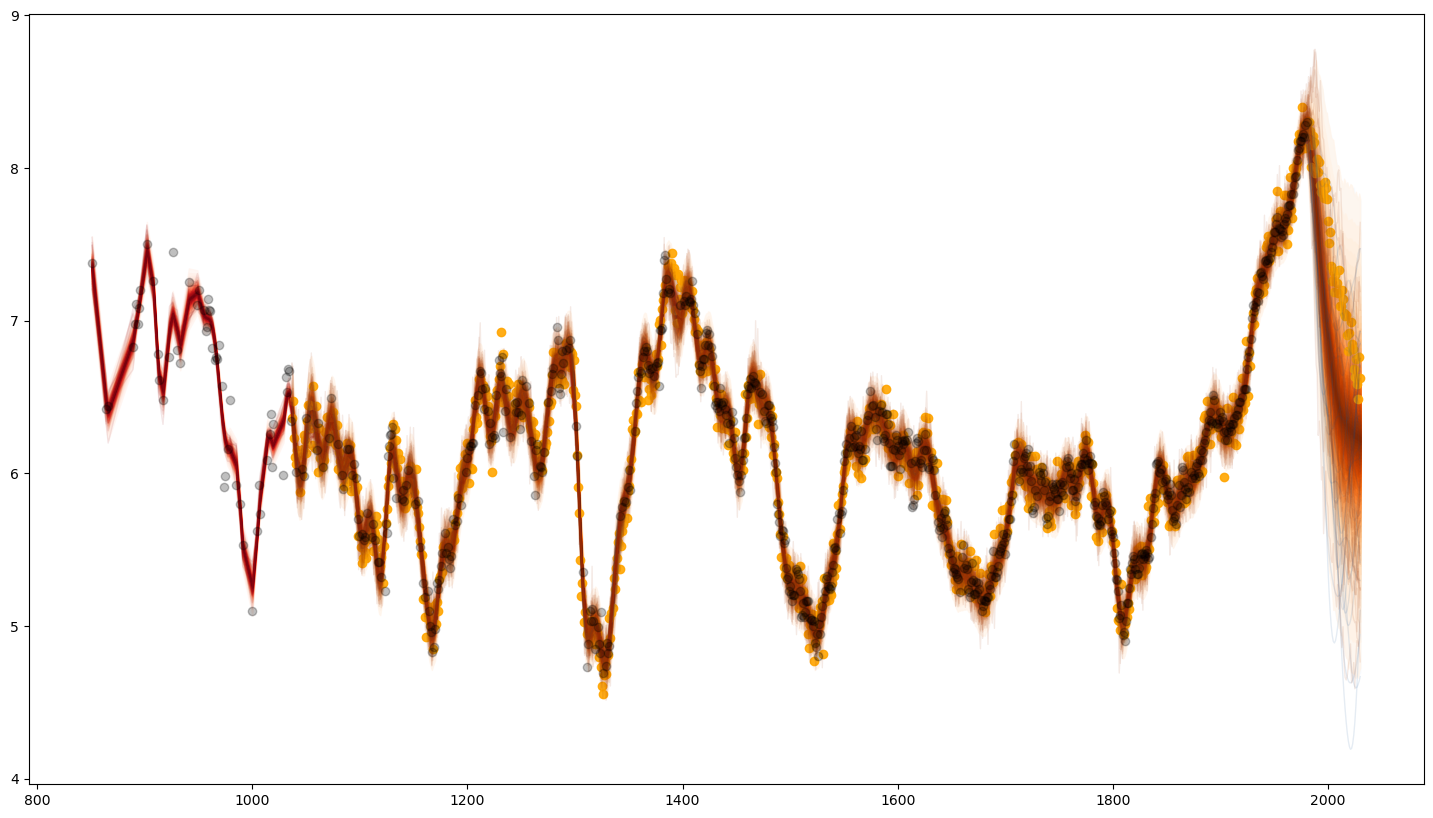

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));
year_gp = idata_gp.posterior.year.values
year_ppc= ppc.posterior_predictive.year.values
#intercept_new= az.extract(ppc, group="posterior_predictive", var_names="intercept_new")
f_new = az.extract(ppc, group="posterior_predictive", var_names="f")
munew = f_new #+ intercept_new
pm.gp.util.plot_gp_dist(ax=ax, x= year_ppc +(year_gp.mean()- year_ppc.mean())-00, samples=munew.values.T, palette="Blues") #+ (year_gp.mean()- year_ppc.mean())

mu = az.extract(idata_gp, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, x= year_gp, samples=mu.values.T)


y_new=az.extract(ppc, group="posterior_predictive", var_names="y")
pm.gp.util.plot_gp_dist(ax=ax, x= year_ppc +(year_gp.mean()- year_ppc.mean())-00, samples=y_new.values.T, palette="Oranges") #+ (year_gp.mean()- year_ppc.mean())
ax.scatter(year_ppc+(year_gp.mean()- year_ppc.mean())-00, ppc.posterior_predictive.sel(dict(chain=2,draw=2)).y, color="orange", alpha=0.9)
ax.plot(df["year"].values, df["temp"].values, "ok", alpha=0.25);

In [260]:
#to use later in doy projection as function of temperature
ppc.posterior_predictive['y']=ppc.posterior_predictive.y.swap_dims({'y_dim_2':'year'})
temp_project_sample = ppc.posterior_predictive.sel(chain=2,draw=2,year=slice(np.max(x),None ))
temp_project_sample


ValueError: cannot swap from dimension 'y_dim_2' because it is not one of the dimensions of this dataset ('chain', 'draw', 'year')

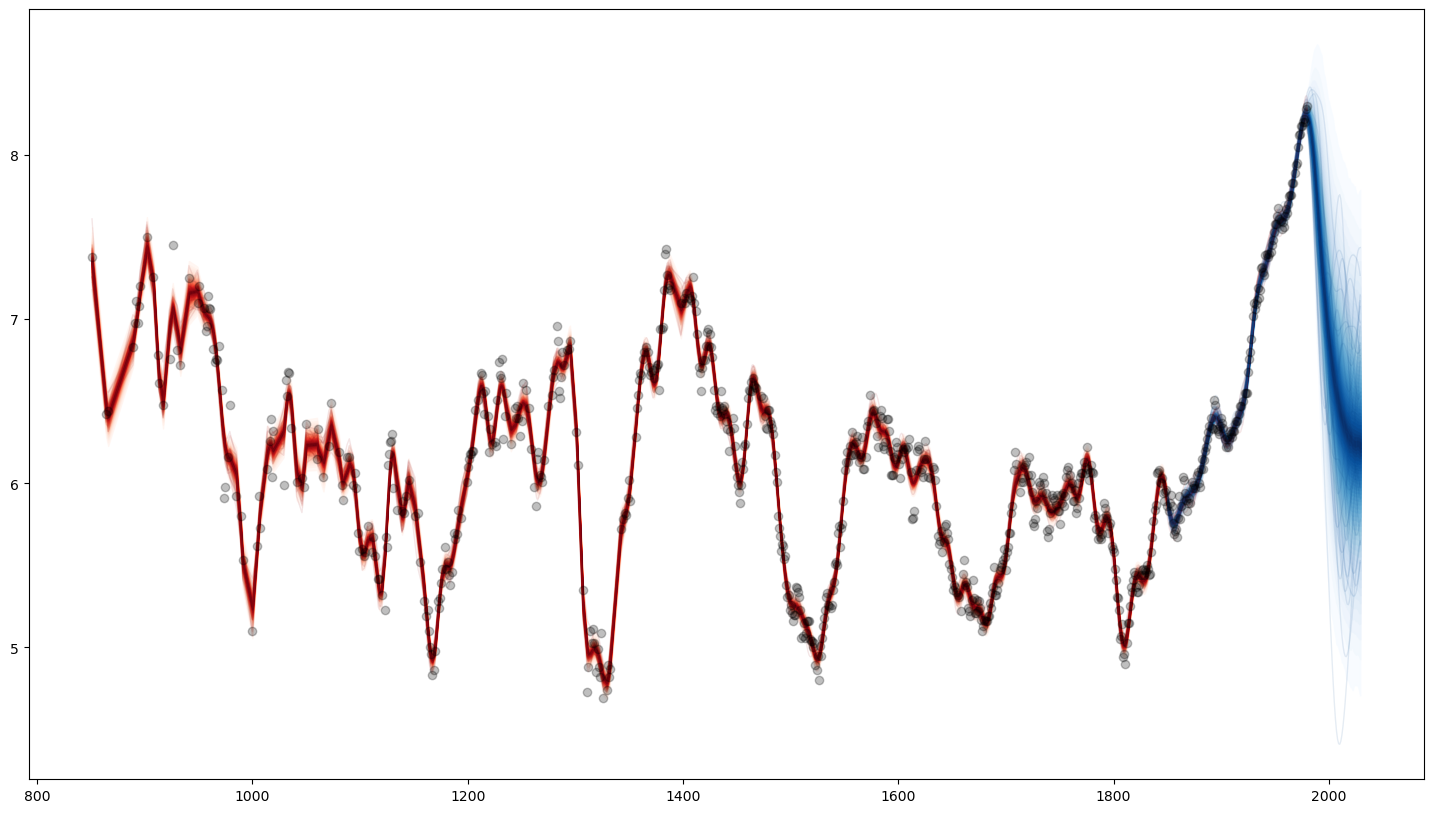

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));

mu = az.extract(idata_gp, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=mu.values.T, x=df["year"].values)

munew = az.extract(ppc, group="posterior_predictive", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=munew.values.T, x=x_new, palette="Blues")

ax.plot(df["year"].values, df["temp"].values, "ok", alpha=0.25);

A GP with a Matern$^{\frac{5}{2}}$ covariance function is mean-reverting.  Even though there is a recent temperature increase, it goes well outside the range of previous data, so the GP tries to send it back to the mean quickly.  If we suspect something in particular happened in the early 1800s that might influence global temperatures, we'd need to consider a model that reflected some sort of changepoint here.  I think the result from the GP makes sense in the context of the model.

# Continue modeling

Now that we've got HSGPs working let's continue modeling.  First we'll fit day of year of the first bloom as a function of time.  

## First bloom as a function of time

We'll use similar logic as before, except it's a bit harder to discern a pattern visually.  Using the same GP prior, we get:

/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/cov.py:190: UserWarning:Only 1 column(s) out of Shape_i{1}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.


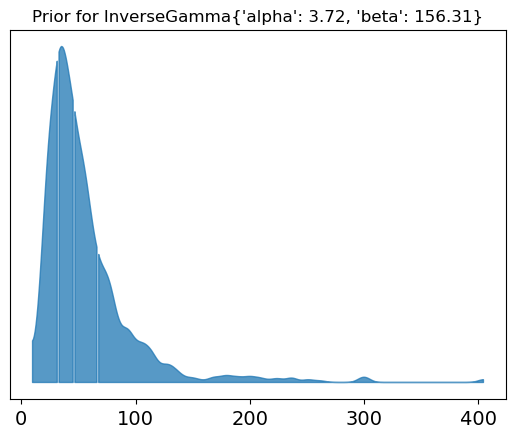

In [180]:
x = df["year"].values

with pm.Model(coords=coords) as model:
    # Set prior on GP hyperparameters
    eta = pm.Exponential("eta", lam=0.25)
    ell_params = belk_find_constrained_prior(
        pm.InverseGamma, 
        lower=20, upper=200, 
        init_guess={"alpha": 2, "beta": 20},
        mass=0.95,
    )
    ell = pm.InverseGamma("ell", **ell_params)
    
    # Specify covariance function and GP
    cov = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    gp = pm.gp.HSGP(m=[400], L=[1365.0], cov_func=cov)
    
    x_mu = np.mean(x)
    X = pm.MutableData("X", x[:, None])
    X = X - x_mu
    
    phi, sqrt_psd = gp.prior_linearized(X)
    beta = pm.Normal("beta", size=400)
    f = pm.Deterministic("f", phi @ (beta * sqrt_psd)) 
    
    intercept = pm.Normal("intercept", mu=df["doy"].mean(), sigma=2 * df["doy"].std())
    mu = pm.Deterministic("mu", intercept + f)
    
    sigma = pm.HalfNormal("sigma", sigma=2 * df["doy"].std())
    pm.Normal("y", mu=mu, sigma=sigma, observed=df["doy"].values)

In [181]:
with model:
    idata_gp = pm.sampling_jax.sample_numpyro_nuts(tune=1000, draws=1000, target_accept=0.9)
print("Divergences:", int(idata_gp.sample_stats.diverging.sum().values))

Compiling...


Compilation time = 0:00:03.360143
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:16.575475
Transforming variables...
Transformation time = 0:00:00.793772


Divergences: 1


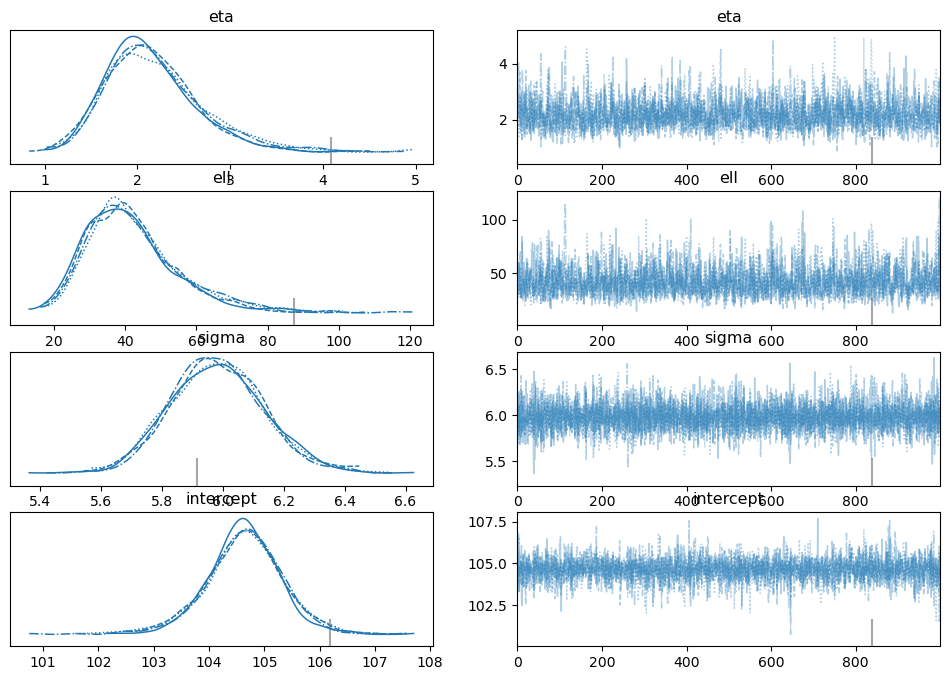

In [182]:
az.plot_trace(idata_gp, var_names=["eta", "ell", "sigma", "intercept"]);

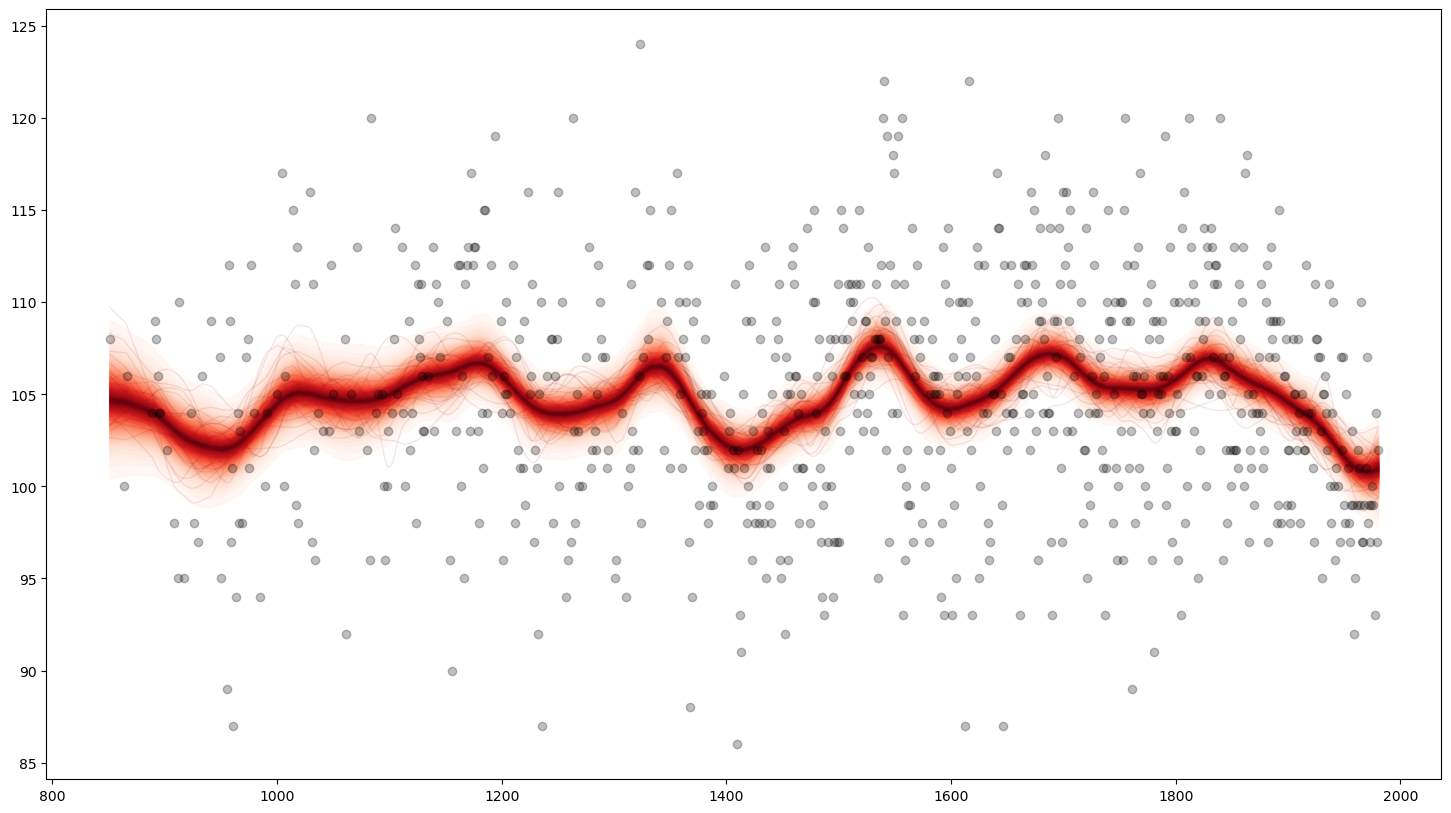

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));

mu = az.extract(idata_gp, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=mu.values.T, x=df["year"].values)
ax.plot(df["year"].values, df["doy"].values, "ok", alpha=0.25);

## Day of year, as a linear function of temperature

Let's drop the GP for a moment and try fitting the day of the first bloom as a function of temperature.  There clearly seems to be some sort of relationship.  As the temperature increases, the cherry trees bloom earlier.  First well fit a simple linear term, then we'll fit an HSGP to see if there is anything non-linear that we can capture in that relationship.

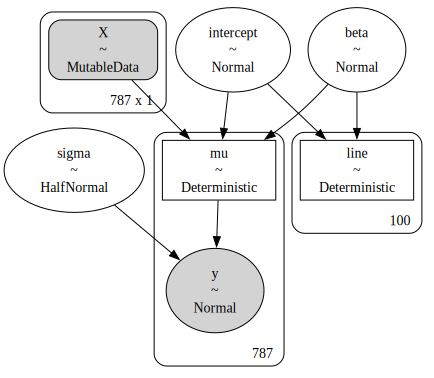

In [186]:
x = df["temp"].values

with pm.Model(coords=coords) as model:
    x_mu = np.mean(x)
    X = pm.MutableData("X", x[:, None])
    X = X - x_mu
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)
    
    intercept = pm.Normal("intercept", mu=0.0, sigma=100)
    mu = pm.Deterministic("mu", intercept + X.flatten() * beta)
    
    sigma = pm.HalfNormal("sigma", sigma=2 * df["doy"].std())
    pm.Normal("y", mu=mu, sigma=sigma, observed=df["doy"].values)
    
    ## record for plotting
    t = np.linspace(np.min(x), np.max(x), 100)
    pm.Deterministic("line", intercept + (t * beta))
pm.model_to_graphviz(model)

In [187]:
with model:
    idata_lin = pm.sampling_jax.sample_numpyro_nuts(tune=1000, draws=1000, target_accept=0.8)
print("Divergences:", int(idata_lin.sample_stats.diverging.sum().values))

Compiling...
Compilation time = 0:00:03.226775
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:02.322515
Transforming variables...
Transformation time = 0:00:00.145778


Divergences: 0


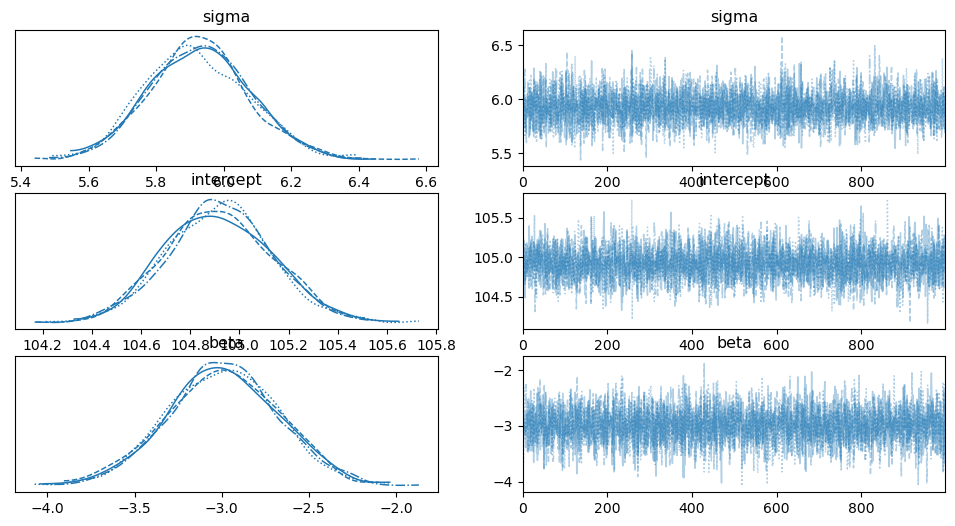

In [188]:
az.plot_trace(idata_lin, var_names=["sigma", "intercept", "beta"]);

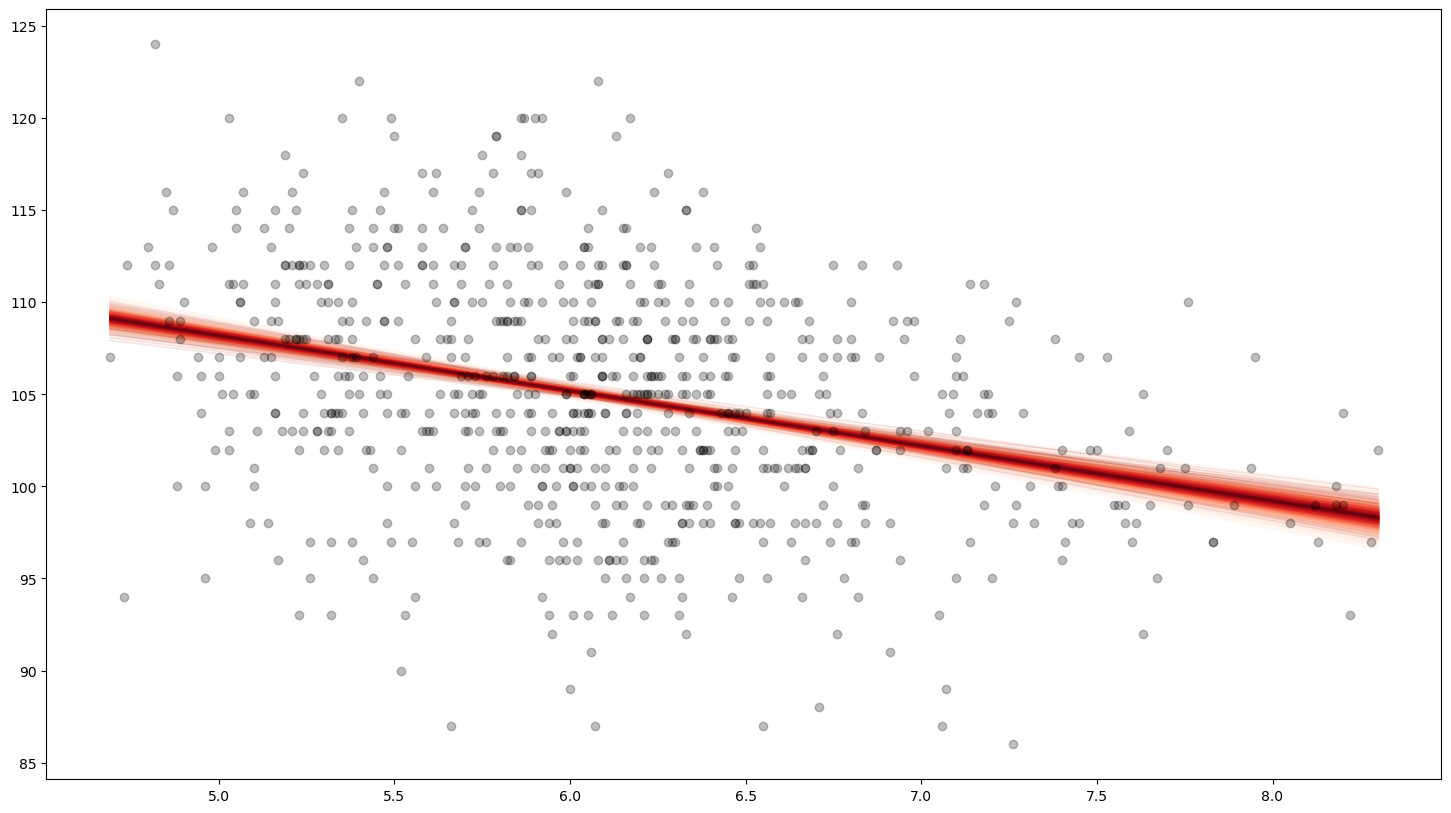

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));

ix = np.argsort(df["temp"].values)

mu = az.extract(idata_lin, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=mu.values.T[:, ix], x=df["temp"].values[ix])
ax.plot(df["temp"].values, df["doy"].values, "ok", alpha=0.25);

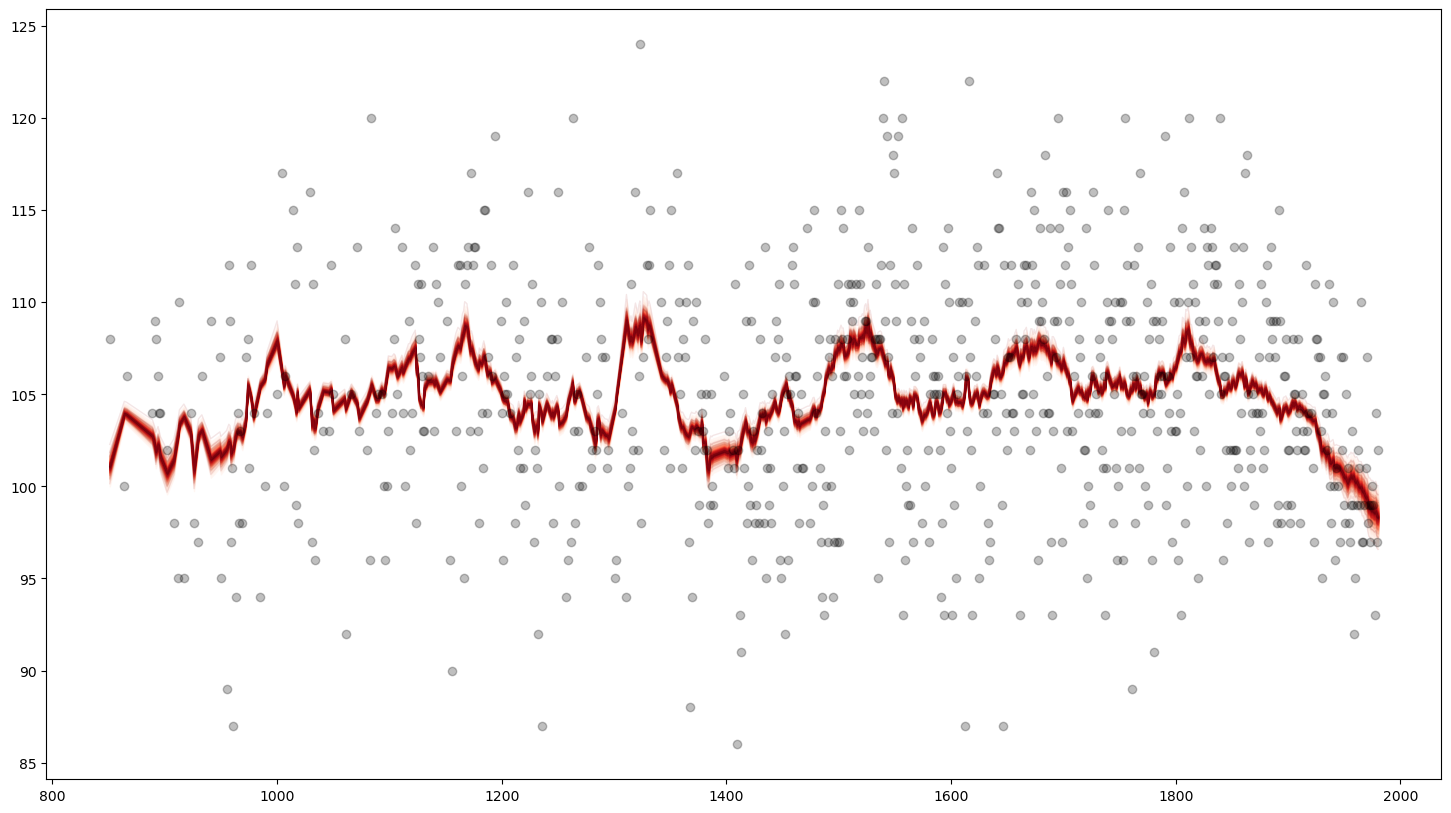

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));

line = az.extract(idata_lin, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=line.values.T, x=df["year"].values)
#ax.plot(df["temp"].values, df["doy"].values, "ok", alpha=0.25);
ax.plot(df["year"].values, df["doy"].values, "ok", alpha=0.25);

## Day of year, using an HSGP

This is the same thing but with an HSGP instead of a linear term.  Note how we set the prior.  Setting priors for GPs is extremely important for using them effectively.  Generally speaking, it's best to be as informative as possible -- which works well when we need to set parameters like `c` and `m`.  This time, we're bounding the prior to lie roughly between 1 and 8.  Let's remake the `m`, `c` plot and see what to choose:

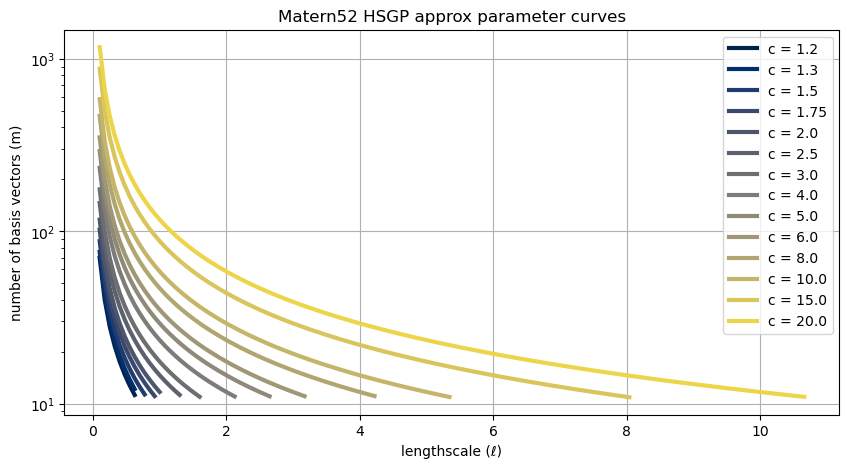

In [191]:
from matplotlib.ticker import MultipleLocator

c_list = np.array([1.2, 1.3, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 20.0])
ell = np.linspace(0.1, 15, 200)
S = (df["temp"] - df["temp"].mean()).max() # half-range of the input data

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

cmap = plt.cm.cividis
colors = np.arange(len(c_list)) / len(c_list)

for i, c in enumerate(c_list):
    m = 2.65 * (c / ell) * S
   
    ix = c >= (4.1 * (ell / S))
    m[~ix] = np.nan
    ax.semilogy(ell, m, color=cmap(colors[i]), label="c = %s" % str(c), lw=3);

ax.grid(True);

ax.set_title("Matern52 HSGP approx parameter curves");
ax.set_xlabel("lengthscale (ℓ)");
ax.set_ylabel("number of basis vectors (m)");
ax.legend();

In [275]:
x = df["temp"].values

with pm.Model() as model:
    model.add_coord('temp', df.temp.tolist(),mutable=True)
    # Set prior on GP hyperparameters
    eta = pm.Exponential("eta", lam=0.25)
    ell_params = pm.find_constrained_prior(
        pm.InverseGamma, 
        lower=1, upper=5, 
        init_guess={"alpha": 2, "beta": 20},
        mass=0.95,
    )
    ell = pm.InverseGamma("ell", **ell_params)
    
    # Specify covariance function and GP
    cov = eta**2 * pm.gp.cov.Matern52(1, ls=ell)
    gp = pm.gp.HSGP(m=[100], L=[33.0], cov_func=cov)  # set c=6.0 first, then use that to find L (call gp.L.eval())
    X= pm.MutableData("X", x[:, None])
    f = gp.prior("f", X=X)   

    intercept = pm.Normal("intercept", mu=df["doy"].mean(), sigma=2 * df["doy"].std())
    mu = pm.Deterministic("mu", intercept + f)
    
    sigma = pm.HalfNormal("sigma", sigma=2 * df["doy"].std())
    pm.Normal("y", mu=mu, sigma=sigma, observed=df["doy"].values, size=X.shape[0])

/home/wmbelk74/anaconda3/envs/Pymc_py311/lib/python3.11/site-packages/pymc/gp/cov.py:190: UserWarning:Only 1 column(s) out of Shape_i{1}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.


In [276]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(tune=1000, draws=1000, target_accept=0.95)
print("Divergences:", int(idata.sample_stats.diverging.sum().values))

Compiling...
Compilation time = 0:00:03.735439
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:18.677134
Transforming variables...
Transformation time = 0:00:00.608745


Divergences: 7


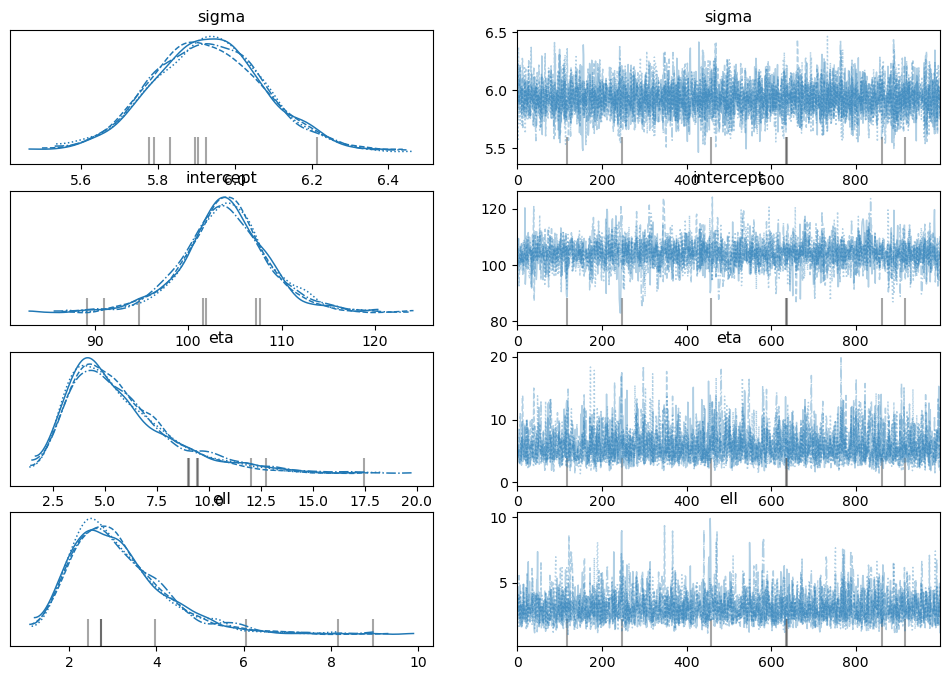

In [277]:
az.plot_trace(idata, var_names=["sigma", "intercept", "eta", "ell"]);

There's still some divergences which should be dealth with, but for now let's just look at the GP for `doy` as a function of `temp`.

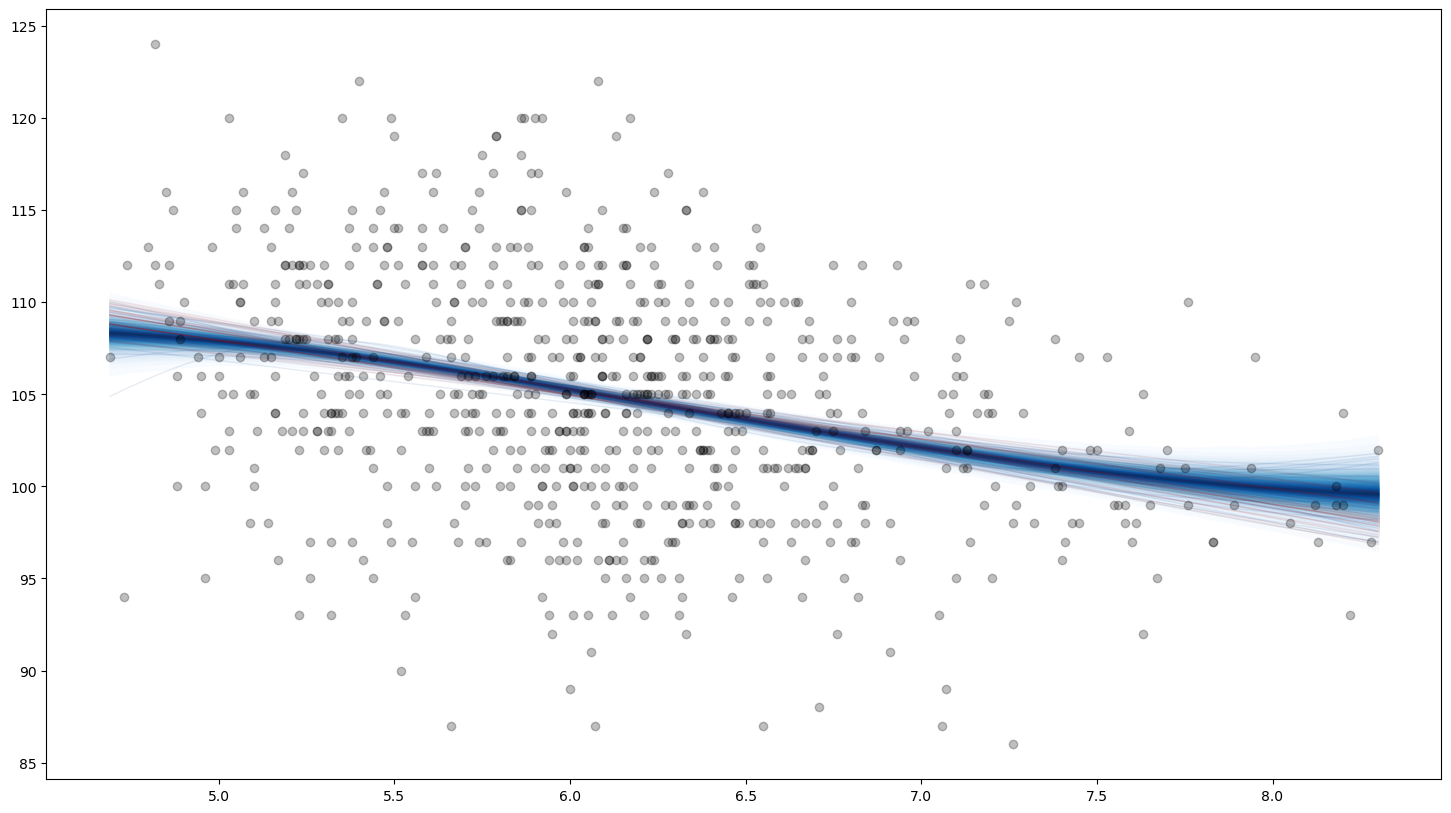

In [278]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));

ix = np.argsort(df["temp"].values)

mu = az.extract(idata_lin, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=mu.values.T[:, ix], x=df["temp"].values[ix])

mu = az.extract(idata, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=mu.values.T[:, ix], x=df["temp"].values[ix], palette="Blues")

ax.plot(df["temp"].values, df["doy"].values, "ok", alpha=0.25);

In [280]:
temp_project_sample


<xarray.Dataset>
Dimensions:  (year: 50, y_dim_2: 994)
Coordinates:
    chain    int64 2
    draw     int64 2
  * year     (year) int64 1980 1981 1982 1983 1984 ... 2025 2026 2027 2028 2029
  * y_dim_2  (y_dim_2) int64 0 1 2 3 4 5 6 7 ... 986 987 988 989 990 991 992 993
Data variables:
    f        (year) float64 8.219 8.189 8.158 8.128 ... 6.648 6.617 6.594 6.58
    y        (year) float64 8.31 8.299 8.242 8.006 ... 6.585 6.487 6.76 6.623
Attributes:
    created_at:                 2024-01-04T09:10:21.250222
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.3

In [296]:

temps_proj = temp_project_sample.y.values
years_proj = temp_project_sample.year.values
extend_temp = np.abs(df["temp"].max() - temps_proj.max())
print(extend_temp)
temps_extended = extend_x_keep_mean(x_extension=2, target_mean=df["temp"].mean(), x=df["temp"].values, make_int=False)

df["temp"].mean()-temps_extended.mean()

0.010335295188472315
x_new.mean()-target_mean=-0.19964421855146242


0.19964421855146242

In [297]:
print( temps_extended.mean(), 
df["temp"].mean(),
df["temp"].max())

5.900711562897076 6.100355781448538 8.3


In [298]:

with model:
    pm.set_data({"X": temps_extended[:, None]})
    ppc = pm.sample_posterior_predictive(idata, var_names=["f", "y"])

Sampling: [y]


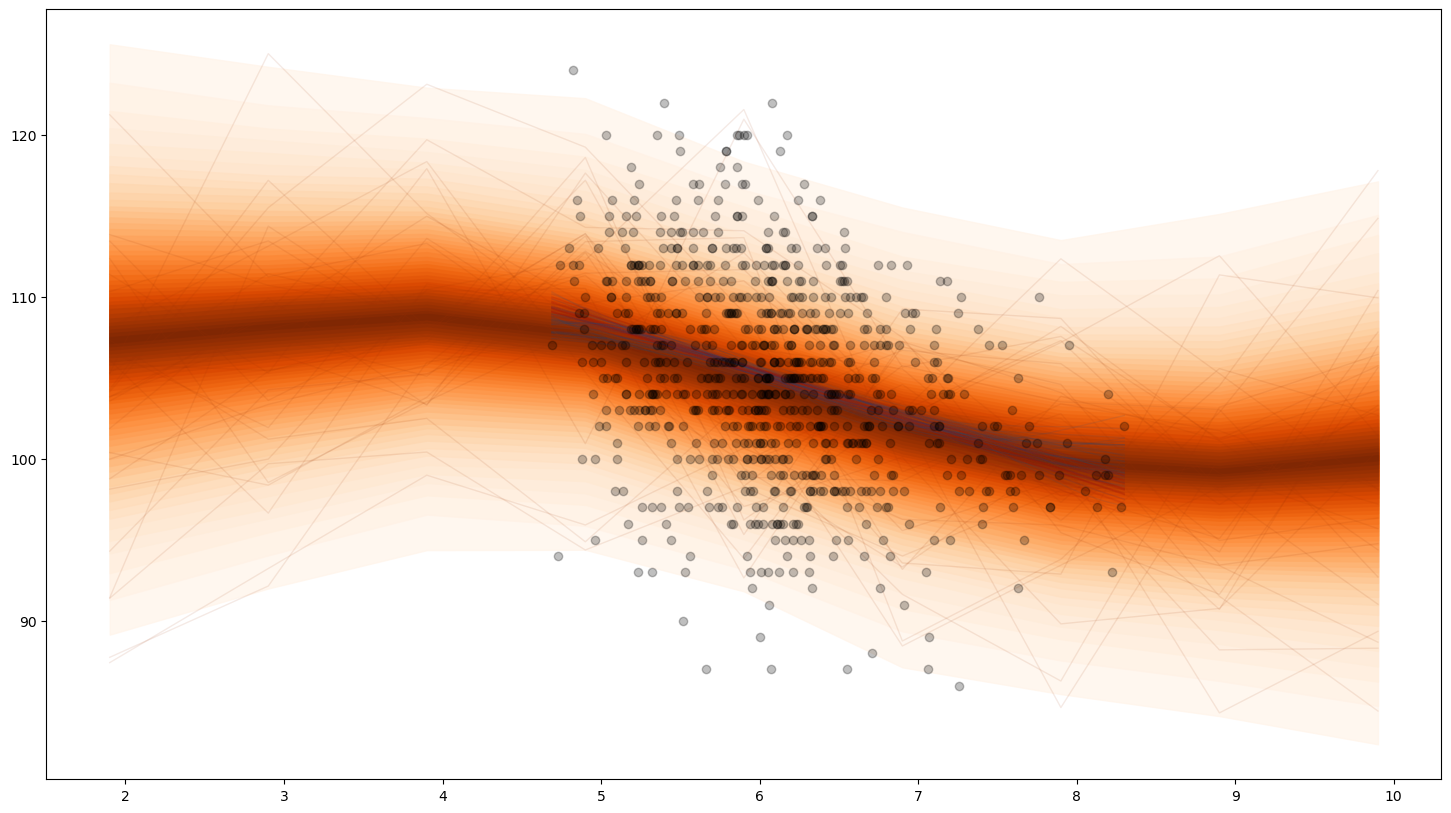

In [301]:
fig, ax = plt.subplots(1, 1, figsize=(18, 10));

ix = np.argsort(df["temp"].values)

mu = az.extract(idata_lin, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=mu.values.T[:, ix], x=df["temp"].values[ix])

mu = az.extract(idata, group="posterior", var_names="mu")
pm.gp.util.plot_gp_dist(ax=ax, samples=mu.values.T[:, ix], x=df["temp"].values[ix], palette="Blues")

mu=az.extract(ppc, group="posterior_predictive", var_names="y")
pm.gp.util.plot_gp_dist(ax=ax, samples=mu.values.T, x=temps_extended, palette="Oranges",)

ax.plot(df["temp"].values, df["doy"].values, "ok", alpha=0.25);

There *might* be a bit of an "S" shape showing up, but it's hard to say if it's material or not.  Either way, it was pretty easy and fast to use a GP to see if we could generalize a result. 

# Conclusion

Hopefully this is enough to get started on using HSGPs in day to day modeling.  There are still more advanced use-cases that we didn't cover.  We'll have some examples up on the PyMC website soon.  